In [11]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.adapt(minimum=28, maximum=136)
cluster

In [12]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.4:38546 Dashboard: http://172.30.100.4:37797/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [13]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import netCDF4 as nc4
import xarray as xr
import os
import matplotlib
import pylab as plt
import numpy as np
import pyproj

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [14]:
def section_from_debut_fin_points(lon_ar7w_debut,lat_ar7w_debut,lon_ar7w_fin,lat_ar7w_fin,navlon,navlat,var):
    
    ee = pyproj.Geod(ellps='GRS80') # ellipsoid used for distance calculation
    
    def distance(lat1,lon1,lat2,lon2,geoid):
        az12,az21,dist = geoid.inv(lon1,lat1,lon2,lat2)
        return dist

    def loclatlon(navlon,navlat,lon,lat):
        ind_debut=np.where((navlon>lon-0.1)&(navlon<lon+0.1)&(navlat>lat-0.1)&(navlat<lat+0.1))
        dis=np.empty(len(ind_debut[0]))
        for ii in range(0,len(ind_debut[0])):
            dis[ii]=np.abs(distance(lat,lon,navlat[ind_debut[0][ii],ind_debut[1][ii]],navlon[ind_debut[0][ii],ind_debut[1][ii]],ee))
        ind=np.argmin(dis)
        i_debut=ind_debut[0][ind]
        j_debut=ind_debut[1][ind]
    
        return i_debut,j_debut
 
    def secfromdebuttofin(i_debut,j_debut,i_fin,j_fin):
        off=1
        fromi=np.atleast_1d(i_debut)+off
        fromj=np.atleast_1d(j_debut)+off
        toi=np.atleast_1d(i_fin)+off
        toj=np.atleast_1d(j_fin)+off

        veci=fromi
        vecj=fromj

        a=(toj-fromj)/((toi-fromi).astype(np.float))
        b=toj-toi*a

        while not((veci[-1]==toi) & (vecj[-1]==toj)):
            newi=veci[-1]+np.sign(toi-fromi)
            newj=vecj[-1]+np.sign(toj-fromj)
            y=a*newi+b
            x=(newj-b)/(a.astype(np.float))

            if ((np.abs(x-veci[-1]))>=(np.abs(y-vecj[-1]))):
                veci=np.append(veci,newi)
                vecj=np.append(vecj,vecj[-1])
            else:
                veci=np.append(veci,veci[-1])
                vecj=np.append(vecj,newj)

        veci=veci.astype(np.int)-off
        vecj=vecj.astype(np.int)-off

        dis=np.empty(len(veci))
        for ii in range(0,len(veci)):
            dis[ii]=np.abs(distance(navlat[veci[0],vecj[0]],navlon[veci[0],vecj[0]],navlat[veci[ii],vecj[ii]],navlon[veci[ii],vecj[ii]],ee))
    
        return veci,vecj,dis
            
    i_debut,j_debut=loclatlon(navlon,navlat,lon_ar7w_debut,lat_ar7w_debut)
    i_fin,j_fin=loclatlon(navlon,navlat,lon_ar7w_fin,lat_ar7w_fin)

    veci,vecj,dis=secfromdebuttofin(i_debut,j_debut,i_fin,j_fin)

    if np.ndim(var) == 4:
        [nt,nk,nj,ni]=var.shape
        var_sec=np.empty([nt,nk,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,:,ii]=var[:,:,veci[ii],vecj[ii]]
    if np.ndim(var) == 3:
        [nt,nj,ni]=var.shape
        var_sec=np.empty([nt,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,ii]=var[:,veci[ii],vecj[ii]]
    
    return veci,vecj,dis,var_sec

In [15]:
gridname = { 'NATL60':'/store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc', 'NACHOS12': '/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75_domain_cfg_newbathy.nc', 'EU36' : '/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'}
wname = { 'NATL60':'/store/molines/NATL60/NATL60-CJM165-S/1d/2012/NATL60-CJM165_y2012m09d07.1d_gridW.nc', 'NACHOS12':'/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-MAA4001-S/1d/2010/NACHOS12.L75-MAA4001_y2010m09d07.1d_gridW.nc', 'EU36':'/scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2010/EU36-MPC001_y2010m09d07.1d_gridW.nc'}
    
def plot_section_iceland_ireland_vertical_noise(simu):
    print('gridname is '+str(gridname[simu]))
    print('wname is '+str(wname[simu]))
    #data and grid
    dgrid=xr.open_dataset(gridname[simu])
    navlon=dgrid['nav_lon']
    navlat=dgrid['nav_lat']
    print('grid file is open')
    dw=xr.open_dataset(wname[simu],chunks={'x':1000,'y':1000,'time_counter':1,'depthw':1})
    w=dw['vovecrtz']
    depthw=dw['depthw']
    print('w is open')
    l=len(depthw)
    #icescotland section beginning and end point
    lon_icescotland_debut=np.array(-14.205).astype(np.float)
    lon_icescotland_fin=np.array(-3.319).astype(np.float)
    lat_icescotland_debut=np.array(64.72).astype(np.float)
    lat_icescotland_fin=np.array(58.988).astype(np.float)
    veci,vecj,dis,wicescotland=section_from_debut_fin_points(lon_icescotland_debut,lat_icescotland_debut,lon_icescotland_fin,lat_icescotland_fin,navlon,navlat,w)
    print('section is computed')
    wicescotland_smooth=np.ones(wicescotland.shape)

    for ii in range(len(veci)):
        profil=wicescotland[0,:,ii]
        window_len=3
        s=np.r_[profil[window_len-1:0:-1],profil,profil[-2:-window_len-1:-1]]
        whanning=np.hanning(window_len)
        yhanning=np.convolve(whanning/whanning.sum(),s,mode='valid')
        wicescotland_smooth[0,:,ii]=yhanning[0:l]
    print('smoothing is done')

    ma_wicescotland = np.ma.array (wicescotland, mask=np.isnan(wicescotland))
    ma_wicescotland_smooth = np.ma.array (wicescotland_smooth, mask=np.isnan(wicescotland_smooth))
    matplotlib.rcParams.update({'font.size': 22})
    plt.figure(figsize=(30,12))
    ax=plt.subplot(1,1,1)
    cmap2 = plt.cm.seismic
    cmap2.set_under('b')
    cmap2.set_over('r')
    pcolor=plt.pcolor(1e-3*dis,depthw,86400*np.abs(ma_wicescotland[0,:,:]-ma_wicescotland_smooth[0,:,:]),cmap='YlOrBr',vmin=0,vmax=10)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='rms')
    ax.set_ylim(1500,0)
    plt.xlabel('distance to Iceland in km')
    plt.ylabel('depth in m')
    plt.title('Indicator for grid noise in Vertical velocities cross-section NACHOS12-MAA4001');


gridname is /scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75_domain_cfg_newbathy.nc
wname is /scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-MAA4001-S/1d/2010/NACHOS12.L75-MAA4001_y2010m09d07.1d_gridW.nc
grid file is open
w is open
section is computed
smoothing is done
CPU times: user 51 s, sys: 6.81 s, total: 57.8 s
Wall time: 1min 56s


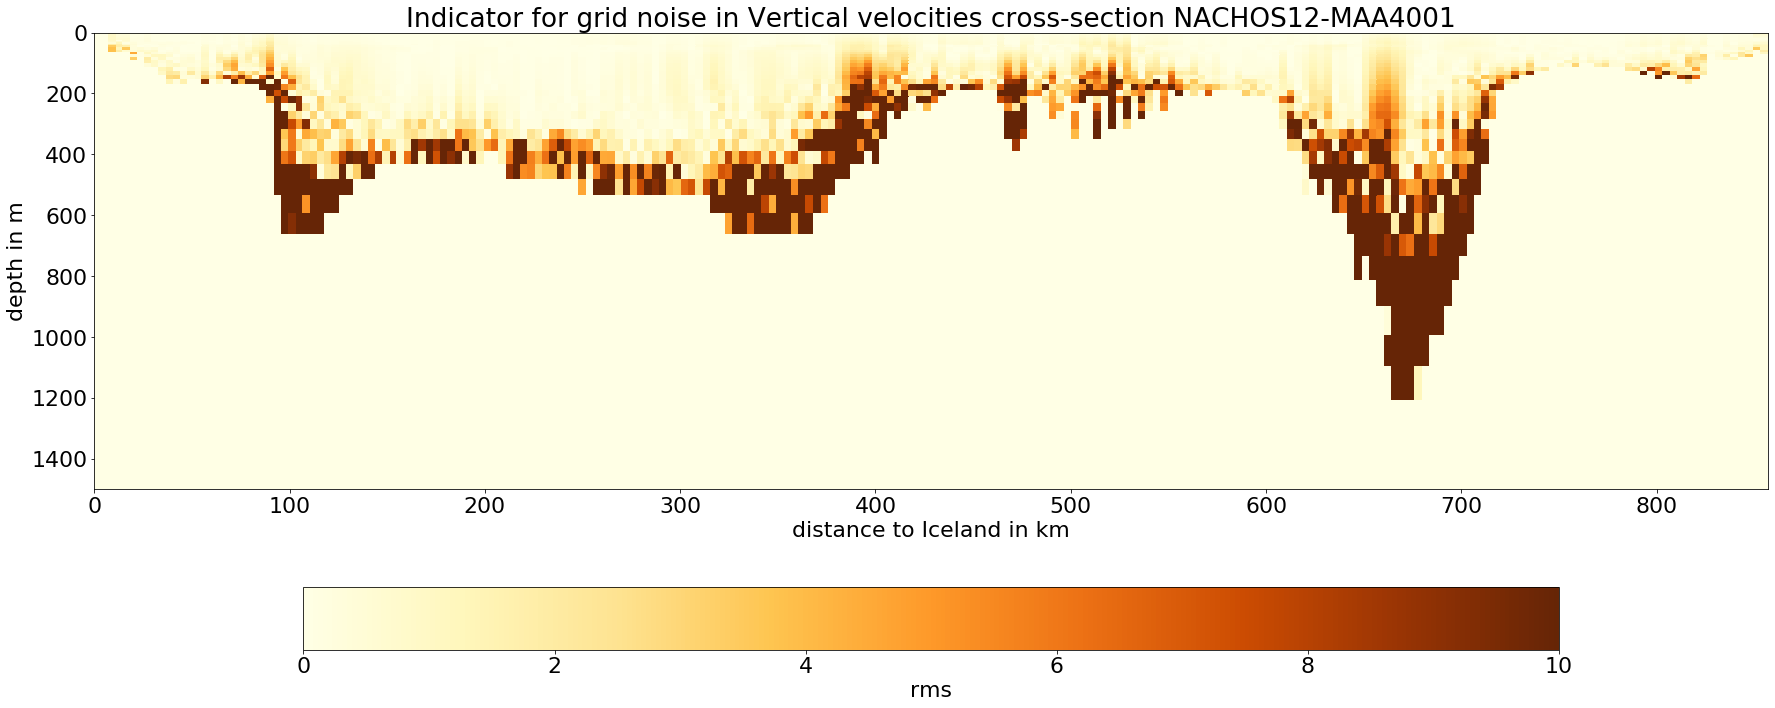

In [16]:
%time plot_section_iceland_ireland_vertical_noise('NACHOS12')

gridname is /scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc
wname is /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2010/EU36-MPC001_y2010m09d07.1d_gridW.nc
grid file is open
w is open
section is computed
smoothing is done
CPU times: user 2min 31s, sys: 18.8 s, total: 2min 49s
Wall time: 4min 19s


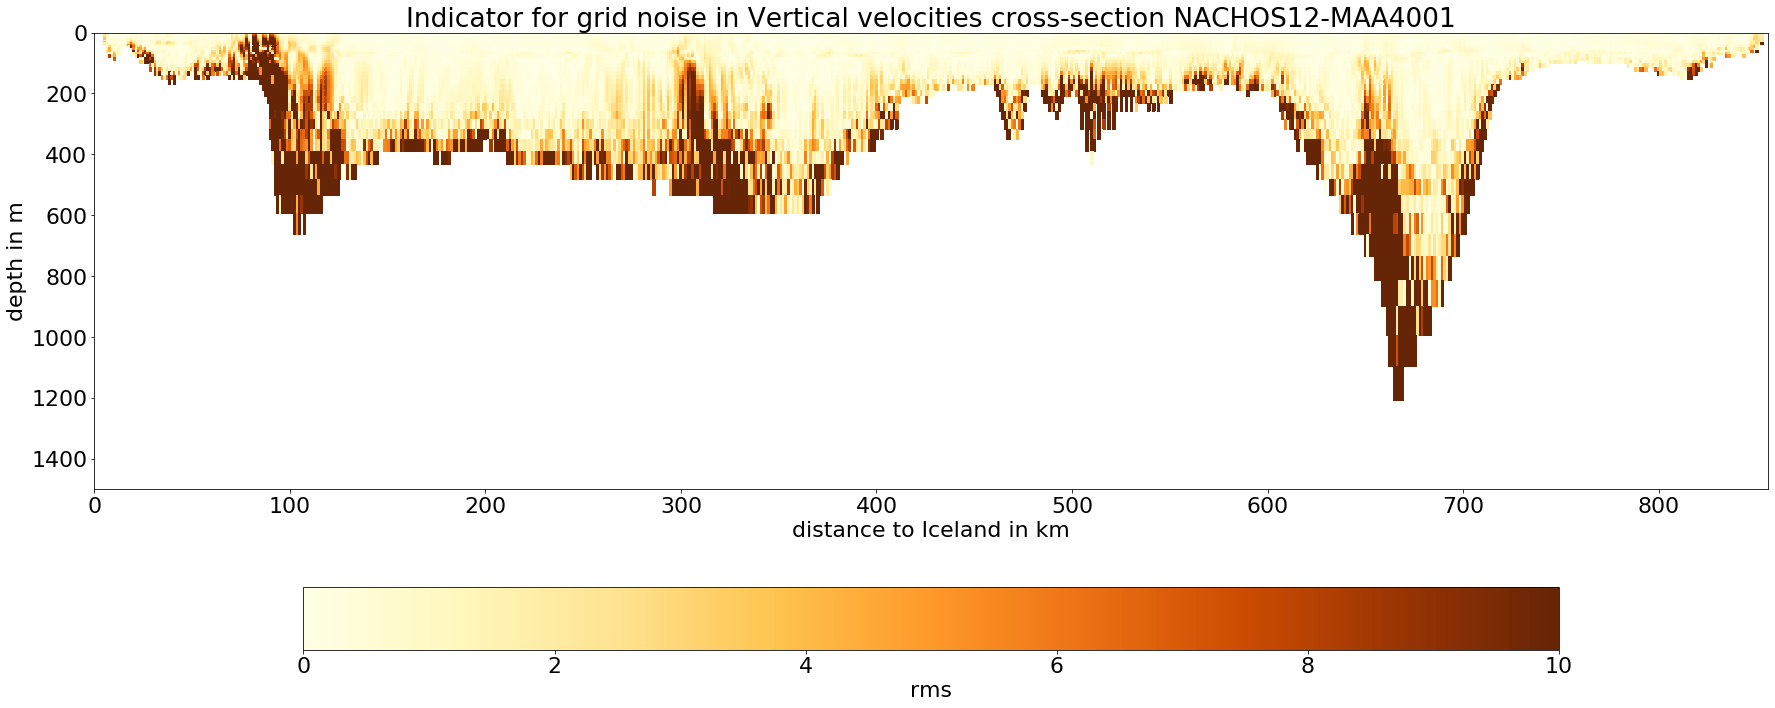

In [17]:
%time plot_section_iceland_ireland_vertical_noise('EU36')

In [ ]:
%time plot_section_iceland_ireland_vertical_noise('NATL60')

gridname is /store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc
wname is /store/molines/NATL60/NATL60-CJM165-S/1d/2012/NATL60-CJM165_y2012m09d07.1d_gridW.nc
grid file is open
w is open
